# set up environment

## magic commands

In [1]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


## NumPy, SciPy, Matplotlib, SymPy

In [2]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


## OS and Colab/Jupyter 

In [3]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [4]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [5]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install control
  !pip install JSAnimation
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')
    

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

# render animations in the notebook
from JSAnimation.IPython_display import display_animation

     |████████████████████████████████| 339 kB 5.2 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=007c2f94be76ad5165edc41d422c76cb5b078fc4c41221741b034d9361d1e1d4
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11425 sha256=e846bf7def79774044a311d9f8830a5fcb86a800258ea627aa284b1236914392
  Stored in directory: /root/.cache/pip/wheels/0e/4e/3d/05fb8cca2646ee0bbfbce17c40a970f48d5e0698b9e5aaa91f
Successfully built JSAnimation


## helpful functions

In [6]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# python-control

The [Python Control Systems Library](https://python-control.readthedocs.io/en/0.8.3/) (`python-control`) provides a suite of computational tools for working with linear systems:
* ***Representation:*** Linear input/output systems in state-space and frequency domain
* ***Block diagram algebra:*** serial, parallel, and feedback interconnections
* ***Time response:*** initial condition, step response, impulse response
* ***Frequency response:*** Bode and Nyquist plots
* ***Controller analysis:*** stability, reachability, observability, stability margins
* ***Controller design:*** eigenvalue placement, linear-quadratic regulator (LQR), robust controllers (H2, Hinf)
* ***Model reduction:*** balanced realizations, Hankel singular values
* ***Estimator design:*** linear quadratic estimator (Kalman filter)

Many of these tools are familiar -- let's see how they're used.

***Note:*** this free Python library replicates most functionality in the [Matlab Control System Toolbox](https://www.mathworks.com/products/control.html) -- in fact, both the Python library and the Matlab toolbox are built on the free and open-source Fortran library [SLICOT](http://slicot.org/); this situation is analogous to the fact that numerical linear algebra in Python and Matlab are both based on the free and open-source Fortran library [LAPACK](http://www.netlib.org/lapack/).  The main thing Matlab has going for it is [Simulink](https://en.wikipedia.org/wiki/Simulink), which is a block diagram GUI that has no Python substitute (for now!).

We'll use the following RLC circuit as our running example:
$$ (\text{DE})\quad L \ddot{q} + R \dot{q} + q/C = u $$
where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $u$ denotes a series voltage source.

Note that `python-control` does not work with symbolic expressions, so we'll need to work with a specific set of parameter values:

In [7]:
R_,L_,C_ = 1.,1.,1. # Ohm, Henry, Farad

## representation

The `python-control` library uses state-space and transfer function representations of linear systems.

### state-space

Letting $x = (q,\dot{q})\in\mathbb{R}^2$ denote the state of the circuit, we can rewrite (DE) in linear state-space form as $\dot{x} = A x + B u$ where

$$ (\text{SS})\quad \dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ (-R\dot{q} - q/C + u)/L \end{array}\right] = \left[ \begin{matrix} 0 & 1 \\ -1/LC & -R/L \end{matrix} \right]\left[ \begin{matrix} q \\ \dot{q} \end{matrix} \right] + \left[ \begin{matrix} 0 \\ 1/L \end{matrix} \right] u = A x + B u.$$

and the output equation $y = C x + D u = \left[\begin{matrix} 1 & 0 \end{matrix}\right] x + \left[\begin{matrix} 0 \end{matrix}\right]\, u$.

In [8]:
A = np.array([[0,1],[-1/(L_*C_),-R_/L_]])
B = np.array([[0],[1/L_]])
C = np.array([[1,0]])
D = np.array([[0]])

ss = ctrl.StateSpace(A, B, C, D)

print(ss)

A = [[ 0.  1.]
     [-1. -1.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



### transfer function

The transfer function corresponding to $\text{(DE)}$ is
$$ (\text{TF})\quad G(s) = \frac{1}{Ls^2 + R s + 1/C}. $$

In `python-control`, we'll specify this transfer function using the sequence of coefficients that multiply powers of $s$ in the numerator `num` and denominator `den` polynomials in descending order:

In [9]:
num = [1.]
den = [L_,R_,1/C_]

tf = ctrl.TransferFunction(num,den)

print(tf)


     1
-----------
s^2 + s + 1



### state-space to/from transfer function

To pass back and forth between state-space and transfer function representations, use `ss2tf` and `tf2ss`:

In [10]:
ctrl.ss2tf(ss)

TransferFunction(array([1.]), array([1., 1., 1.]))

In [11]:
print(ctrl.tf2ss(tf))

A = [[-1. -1.]
     [ 1.  0.]]

B = [[1.]
     [0.]]

C = [[0. 1.]]

D = [[0.]]



***Note:*** since state-space representations aren't unique, the $A,B,C,D$ matrices I get back don't match the ones I started with.

## analysis

### phase portrait

If we specify the differential equation in the form $\dot{x} = f(x,t)$ then we can generate the phase portrait using `phase_plot`.

(-1.0, 1.0)

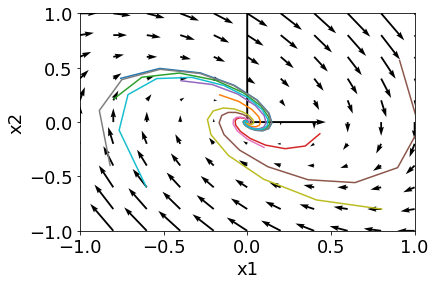

In [12]:
# note: arguments are in opposite order than numerical_simulation
def f(x,t):
  return np.dot(x,A.T)

# X and Y meshes for vector field
# [lower limit, upper limit, number of points]
X,Y = [-1,+1,11],[-1,+1,11]

# initial conditions for streamplots
X0 = 2*np.random.rand(10,2)-1

ctrl.phase_plot(f,X=X,Y=Y,X0=X0)
plt.xlim(X[:2])
plt.ylim(Y[:2])

### impulse response

The `impulse_response` function generates the impulse response for a system in state-space or transfer function form:

Text(0, 0.5, 'output')

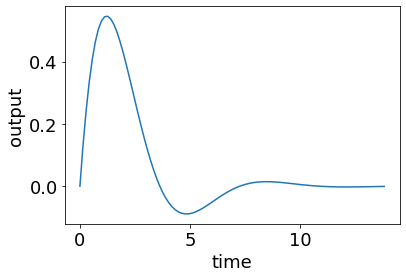

In [13]:
t,y = ctrl.impulse_response(ss)
#t,y = ctrl.impulse_response(tf) # <-- same result

plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('output')

### step response

The `step_response` function generates the step response for a system in state-space or transfer function form:

Text(0, 0.5, 'output')

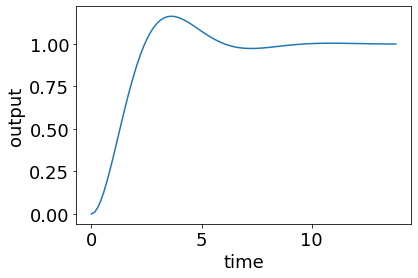

In [14]:
t,y = ctrl.step_response(ss)
#t,y = ctrl.step_response(tf) # <-- same result

plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('output')

### frequency response

To evaluate the system's response to $\sin\omega t$, use `evalfr(sys,w)` where `sys` is `ss` or `tf` and `w` is $\omega$.

For instance, the DC gain is obtained by evaluating at `w=0.`:

In [15]:
ctrl.evalfr(ss,0.)

(1+0j)

There's also a `dcgain` function for determining this quantity specifically.

In [16]:
ctrl.dcgain(ss)

1.0

### Bode plot

The `bode_plot` function generates a Bode plot for a system in state-space or transfer function form:

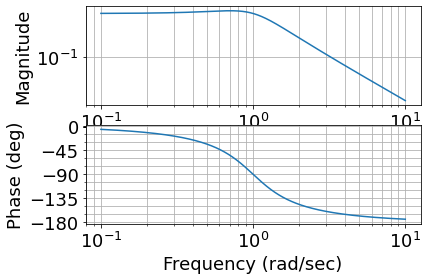

In [17]:
ctrl.bode_plot(ss);

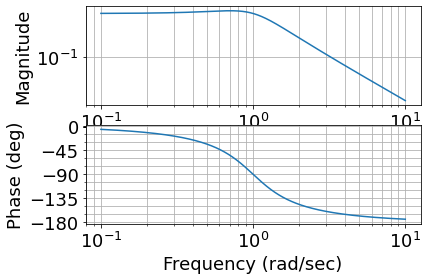

In [18]:
ctrl.bode_plot(tf);

### poles and zeros

The poles and zeros (i.e. roots of the denominantor and numerator polynomials of the transfer function representation) can be computed using the `pole` and `zero` functions:

In [19]:
ctrl.pole(ss)

array([-0.5+0.866j, -0.5-0.866j])

In [20]:
ctrl.zero(ss)

array([], dtype=float64)

### root locus

***Note:*** this routine only generates root locus plots as $k_P$ varies in $u = - k_P y$.

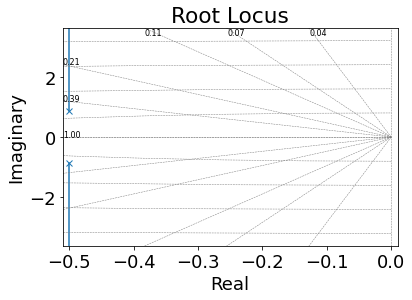

In [21]:
ctrl.root_locus(ss);

## nonlinear system

The `python-control` module is primarily designed to work with linear systems, but there are tools for extracting a linear system from a nonlinear system through linearization.

We'll apply these techniques to the inverted pendulum, which consists of a massless rod of length $\ell$ with a point mass $m$ affixed to one end and a rotational joint affixed to the other end,
$$
m \ell^2 \ddot{q} = m g \ell \sin q - \alpha\dot{q} + \ell u \cos q,
$$
where
$q$ is the pendulum angle,
$\alpha > 0$ is a coefficient of rotational friction,
and $u$ is the horizontal acceleration of the pivot point.

We'll assume we obtain nonlinear measurements of the pendulum angle,

$$ y = \ell\sin q. $$

In [43]:
# pendulum parameters
m_ = 1.    # kg
l_ = 0.5   # m
g_ = 9.81  # m / sec^2
a_ = .5

# \dot{x} = f(t,x,u,p)
def f(t,x,u,p):
  q,dq = x
  ddq = (m_*g_*l_*np.sin(q) - a_*dq + l_*u*np.cos(q)) / (m_*l_**2)
  return np.array([dq,ddq])

# y = h(t,x,u,p)
def h(t,x,u,p):
  q,dq = x
  return np.array([l_*np.sin(q)])

### representation

To create a nonlinear system object, we pass the $f$ and $h$ functions defined above into the `NonlinearIOSystem` tool:

In [44]:
nl = ctrl.NonlinearIOSystem(f,h)

print(nl)

System: sys[6]
Inputs (None): 
Outputs (None): 
States (None): 


***Note:*** `IO` stands for 'input/output'.


Although this definition will work, the `print` isn't very informative -- we can provide more descriptive detail about the number of inputs, outputs, and states, and their meaning, using additional arguments:

In [45]:
nl = ctrl.NonlinearIOSystem(f,h,inputs=['force'],outputs=['angle'],
                                states=['angle','angular velocity'])

print(nl)

System: sys[7]
Inputs (1): force, 
Outputs (1): angle, 
States (2): angle, angular velocity, 


### simulation

The `input_output_response` function simulates the nonlinear system from a specified initial condition and returns the output (and, optionally, state) at specified time points -- this is the `python-control` equivalent of my `numerical_simulation` function.

Text(0.5, 0, 'time')

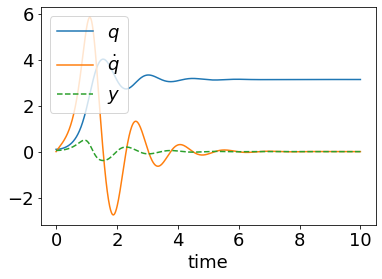

In [46]:
x0 = np.array([.1,0])
t = np.linspace(0, 10, 1000)

# Simulate the system
t, y, x = ctrl.input_output_response(nl, t, 0, x0, return_x=True)
q,dq = x

# Plot the response
plt.plot(t, q, label=r'$q$')
plt.plot(t, dq, label=r'$\dot{q}$')
plt.plot(t, y, '--', label=r'$y$')
plt.legend()
plt.xlabel('time')

Note that the simulation diverges from the equilibrium at $(0,0)$ and converges to the equilibrium at $(\pi,0)$.

### equilibrium



To find an equilibrium near a given state vector, we use numerical root finding:

In [47]:
def find_eqpt(nl,x,u=[]):
  from scipy.optimize import root
  f0 = lambda z : nl.updfcn(0,z,u,None)
  res = root(f0,x)
  return res['x']

In [48]:
ueq = 0.
xeq = find_eqpt(nl,x0,ueq)
xeq

array([0., 0.])

The `find_eqpt` tool should do the same thing, but currently returns an error I haven't been able to debug:

In [49]:
xeq = ctrl.find_eqpt(nl, x0, ueq)
xeq

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


TypeError: ignored

error: ignored

### linearization

We can linearize about a given equilibrium using the `linearize` tool:

In [50]:
l = ctrl.linearize(nl,xeq,ueq)
print(l)

System: sys[8]
Inputs (1): u[0], 
Outputs (1): y[0], 
States (2): x[0], x[1], 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


The `linearize` tool returns a new system with the $A,B,C,D$ matrices as attributes:

In [51]:
A,B,C,D = l.A,l.B,l.C,l.D
print('A=',A)
print('B=',B)
print('C=',C)
print('D=',D)

A= [[ 0.    1.  ]
 [19.62 -2.  ]]
B= [[0.]
 [2.]]
C= [[0.5 0. ]]
D= [[0.]]


The matrices obtained from the linearization can be used to define a state-space linear system:

In [52]:
ss = ctrl.ss(A,B,C,D)
print(ss)

A = [[ 0.    1.  ]
     [19.62 -2.  ]]

B = [[0.]
     [2.]]

C = [[0.5 0. ]]

D = [[0.]]



The linear system can then be analyzed using the tools above, e.g. we can generate a Bode plot:

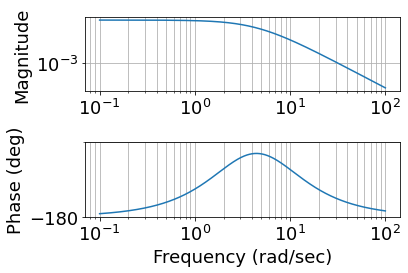

In [53]:
ctrl.bode_plot(ss);
plt.tight_layout()

## interconnection

Continuing with the inverted pendulum from the preceding section, 

In [54]:
A = np.array([[ 0., 1.],[19.62, -2.]])
B = np.array([[0], [2]])
C = np.array([[.5, 0]])
D = np.array([[0]])

ss = ctrl.ss(A,B,C,D)

note that the system is unstable because one pole (i.e. eigenvalue) of $A$ has positive real part:

In [55]:
ctrl.pole(ss)

array([ 3.541, -5.541])

Fortunately, this system can be stabilized by proportional feedback, as can be seen from the root locus diagram (which shows how the poles of the closed-loop system obtained with $u = - k_P y$ vary as the proportional gain $k_P$ varies):

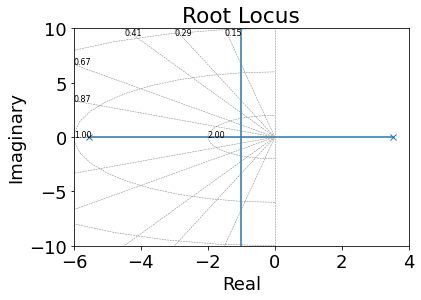

In [56]:
r,k_P = ctrl.root_locus(ss,kvect=np.linspace(0,100,1000),
                        xlim=(-6,4),ylim=(-10,+10));

The diagram indicates that the system ***can*** be stabilized by proportional feebdack (because for sufficiently large gains, both poles have negative real part), so we can check how large $k_P$ needs to be:

In [57]:
print('k_P > %0.1f'%k_P[np.all(r.real < 0,axis=1).nonzero()[0][0]])

k_P > 19.7


And we can verify this calculation by determining the poles (i.e. eigenvalues) of the closed-loop system with gains that are a little larger (real part of all eigenvalues should be negative) and a little smaller (at least one of the eigenvalues should have positive real part).

In [58]:
# too small -- system is unstable
k_P = 19
la.eigvals(A - k_P*np.dot(B,C))

array([ 0.273+0.j, -2.273+0.j])

In [59]:
# large enough -- system is stable
k_P = 20
la.eigvals(A - k_P*np.dot(B,C))

array([-0.213+0.j, -1.787+0.j])

We'll close the loop by creating a proportional controller as a separate system and interconnecting it with the process -- note that the poles of the interconnected system `ctrl.pole(S)` are the same as the eigenvalues of the closed-loop matrix $A - k_PB C$:

In [60]:
P = ss # state-space model defined above
C = ctrl.tf(k_P,1) # transfer function representation of proportional control

# sign = -1 indicates negative feedback
S = ctrl.feedback(P,C,sign=-1)

ctrl.pole(S)

array([-0.213, -1.787])